In [9]:
#!pip install -U segmentation-models-pytorch

import libraries

In [108]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from albumentations import Compose, Resize
from albumentations.pytorch import ToTensorV2
from torchmetrics.classification import BinaryJaccardIndex
from tqdm import tqdm
import torch.nn as nn
from torchinfo import summary
from torchvision import models
from PIL import Image
from torchvision import transforms

mount google drive

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


function to map polygon to image masks - training data

In [109]:
images_dir = "./dataset/train/images"
labels_dir = "./dataset/train/labels"
masks_dir = "./dataset/train/output_masks"
os.makedirs(masks_dir, exist_ok=True)

for img_file in os.listdir(images_dir):
    if not img_file.endswith(('.jpg', '.png')):
        continue
    img_path = os.path.join(images_dir, img_file)
    label_path = os.path.join(labels_dir, os.path.splitext(img_file)[0] + '.txt')
    mask_path = os.path.join(masks_dir, os.path.splitext(img_file)[0] + '.png')
    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not load image {img_path}")
        continue
    h, w = img.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)
    if os.path.exists(label_path):
        with open(label_path) as f:
            for line in f:
                items = list(map(float, line.strip().split()))
                cls = int(items[0]) + 1  # background=0, class 0=1, etc
                points = np.array(items[1:]).reshape(-1, 2)
                points[:, 0] *= w
                points[:, 1] *= h
                points = points.astype(np.int32)
                cv2.fillPoly(mask, [points], cls)
    cv2.imwrite(mask_path, mask)

function to map polygon to image masks - validation data

In [110]:
images_dir = "./dataset/valid/images"
labels_dir = "./dataset/valid/labels"
masks_dir = "./dataset/valid/output_masks"
os.makedirs(masks_dir, exist_ok=True)

for img_file in os.listdir(images_dir):
    if not img_file.endswith(('.jpg', '.png')):
        continue
    img_path = os.path.join(images_dir, img_file)
    label_path = os.path.join(labels_dir, os.path.splitext(img_file)[0] + '.txt')
    mask_path = os.path.join(masks_dir, os.path.splitext(img_file)[0] + '.png')
    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not load image {img_path}")
        continue
    h, w = img.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)
    if os.path.exists(label_path):
        with open(label_path) as f:
            for line in f:
                items = list(map(float, line.strip().split()))
                cls = int(items[0]) + 1
                points = np.array(items[1:]).reshape(-1, 2)
                points[:, 0] *= w
                points[:, 1] *= h
                points = points.astype(np.int32)
                cv2.fillPoly(mask, [points], cls)
    cv2.imwrite(mask_path, mask)

show example data

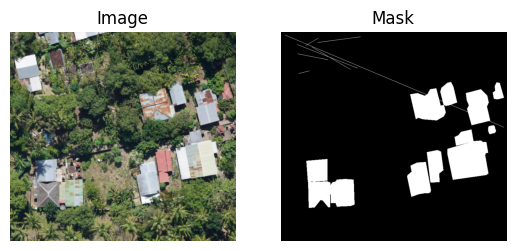

In [111]:
img = cv2.imread('./dataset/valid/images/Screenshot-2025-03-01-224236_png.rf.2b5295a45ee7ab530f027f63eafca4d1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread('./dataset/valid/output_masks/Screenshot-2025-03-01-224236_png.rf.2b5295a45ee7ab530f027f63eafca4d1.png', cv2.IMREAD_GRAYSCALE)

plt.subplot(1,2,1); plt.imshow(img); plt.axis('off'); plt.title('Image')
plt.subplot(1,2,2); plt.imshow(mask, cmap='gray'); plt.axis('off'); plt.title('Mask')
plt.show()

segmentation dataset

In [112]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.files = [f for f in os.listdir(images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        img_path = os.path.join(self.images_dir, img_name)

        mask_name = os.path.splitext(img_name)[0] + '.png'
        mask_path = os.path.join(self.masks_dir, mask_name)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if mask is None:
            raise FileNotFoundError(f"Mask file not found or could not be opened: {mask_path}")

        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        image = torch.tensor(image, dtype=torch.float).permute(2,0,1)/255.0
        mask = torch.tensor(mask, dtype=torch.long)
        return image, mask

data load

In [113]:
train_transform = Compose([
    Resize(256, 256),
])

valid_transform = Compose([
    Resize(256, 256),
])

train_dataset = SegmentationDataset(
    images_dir='./dataset/train/images',
    masks_dir='./dataset/train/output_masks',
    transform=train_transform
)
valid_dataset = SegmentationDataset(
    images_dir='./dataset/valid/images',
    masks_dir='./dataset/valid/output_masks',
    transform=valid_transform
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

dice loss

In [114]:
import torch.nn as nn

class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        logits = torch.sigmoid(logits)
        logits = logits.view(-1)
        targets = targets.view(-1)

        intersection = (logits * targets).sum()
        dice = (2. * intersection + self.smooth) / (logits.sum() + targets.sum() + self.smooth)
        return 1 - dice

define model

In [116]:
model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b0",        
    encoder_weights="imagenet",     
    in_channels=3,
    classes=1,                      
)

loss_fn = lambda logits, targets: 0.5 * nn.BCEWithLogitsLoss()(logits, targets) + 0.5 * DiceLoss()(logits, targets) 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train the data

In [117]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
epochs_input = 80


jaccard = BinaryJaccardIndex().to(device)
best_score = 0.0

for epoch in range(epochs_input):
    print(f"\nEpoch [{epoch+1}/{epochs_input}]")

    # --- Training ---
    model.train()
    train_loss = 0.0
    for images, masks in tqdm(train_loader, desc="Training", leave=False):
        try:
            images = images.to(device)
            masks = masks.unsqueeze(1).float().to(device)

            optimizer.zero_grad()
            outputs = model(images)   
            loss = loss_fn(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        except Exception as e:
            print(f"Error in training batch: {e}")

    avg_train_loss = train_loss / len(train_loader)
    print(f"Training Loss: {avg_train_loss:.4f}")

    model.eval()
    jaccard.reset()
    val_loss = 0.0

    with torch.no_grad():
        for images, masks in tqdm(valid_loader, desc="Validating", leave=False):
            try:
                images = images.to(device)
                masks = masks.unsqueeze(1).float().to(device)

                outputs = model(images)
                loss = loss_fn(outputs, masks)
                val_loss += loss.item()

                preds = torch.sigmoid(outputs)
                preds = (preds > 0.5).float()
                jaccard.update(preds, masks.int())

            except Exception as e:
                print(f"Error in validation batch: {e}")

    avg_val_loss = val_loss / len(valid_loader)
    epoch_iou = jaccard.compute().item()
    print(f"Validation Loss: {avg_val_loss:.4f} | IoU: {epoch_iou:.4f}")

    if epoch_iou > best_score:
        best_score = epoch_iou
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Best model saved.")


Epoch [1/80]


Training Loss: 0.2979


Validation Loss: 0.5287 | IoU: 0.1724
✅ Best model saved.

Epoch [2/80]


Training Loss: 0.1411


Validation Loss: 0.3850 | IoU: 0.4274
✅ Best model saved.

Epoch [3/80]


Training Loss: 0.1056


Validation Loss: 0.3504 | IoU: 0.5364
✅ Best model saved.

Epoch [4/80]


Training Loss: 0.0886


Validation Loss: 0.3232 | IoU: 0.6068
✅ Best model saved.

Epoch [5/80]


Training Loss: 0.0813


Validation Loss: 0.3257 | IoU: 0.6326
✅ Best model saved.

Epoch [6/80]


Training Loss: 0.0736


Validation Loss: 0.3459 | IoU: 0.6251

Epoch [7/80]


Training Loss: 0.0719


Validation Loss: 0.3327 | IoU: 0.6403
✅ Best model saved.

Epoch [8/80]


Training Loss: 0.0637


Validation Loss: 0.3176 | IoU: 0.6436
✅ Best model saved.

Epoch [9/80]


Training Loss: 0.0616


Validation Loss: 0.3415 | IoU: 0.6432

Epoch [10/80]


Training Loss: 0.0592


Validation Loss: 0.3322 | IoU: 0.6466
✅ Best model saved.

Epoch [11/80]


Training Loss: 0.0547


Validation Loss: 0.3420 | IoU: 0.6503
✅ Best model saved.

Epoch [12/80]


Training Loss: 0.0524


Validation Loss: 0.3530 | IoU: 0.6499

Epoch [13/80]


Training Loss: 0.0576


Validation Loss: 0.4094 | IoU: 0.6333

Epoch [14/80]


Training Loss: 0.0576


Validation Loss: 0.3709 | IoU: 0.6425

Epoch [15/80]


Training Loss: 0.0563


Validation Loss: 0.3672 | IoU: 0.6430

Epoch [16/80]


Training Loss: 0.0471


Validation Loss: 0.3370 | IoU: 0.6521
✅ Best model saved.

Epoch [17/80]


Training Loss: 0.0434


Validation Loss: 0.3572 | IoU: 0.6523
✅ Best model saved.

Epoch [18/80]


Training Loss: 0.0424


Validation Loss: 0.3682 | IoU: 0.6522

Epoch [19/80]


Training Loss: 0.0415


Validation Loss: 0.3554 | IoU: 0.6538
✅ Best model saved.

Epoch [20/80]


Training Loss: 0.0397


Validation Loss: 0.3556 | IoU: 0.6548
✅ Best model saved.

Epoch [21/80]


Training Loss: 0.0383


Validation Loss: 0.3661 | IoU: 0.6538

Epoch [22/80]


Training Loss: 0.0374


Validation Loss: 0.3844 | IoU: 0.6559
✅ Best model saved.

Epoch [23/80]


Training Loss: 0.0369


Validation Loss: 0.3829 | IoU: 0.6517

Epoch [24/80]


Training Loss: 0.0376


Validation Loss: 0.4017 | IoU: 0.6529

Epoch [25/80]


Training Loss: 0.0356


Validation Loss: 0.3733 | IoU: 0.6554

Epoch [26/80]


Training Loss: 0.0376


Validation Loss: 0.3701 | IoU: 0.6526

Epoch [27/80]


Training Loss: 0.0371


Validation Loss: 0.3864 | IoU: 0.6528

Epoch [28/80]


Training Loss: 0.0347


Validation Loss: 0.3615 | IoU: 0.6522

Epoch [29/80]


Training Loss: 0.0362


Validation Loss: 0.4048 | IoU: 0.6536

Epoch [30/80]


Training Loss: 0.0337


Validation Loss: 0.4070 | IoU: 0.6534

Epoch [31/80]


Training Loss: 0.0323


Validation Loss: 0.4153 | IoU: 0.6529

Epoch [32/80]


Training Loss: 0.0321


Validation Loss: 0.4106 | IoU: 0.6540

Epoch [33/80]


Training Loss: 0.0314


Validation Loss: 0.3918 | IoU: 0.6562
✅ Best model saved.

Epoch [34/80]


Training Loss: 0.0309


Validation Loss: 0.4191 | IoU: 0.6567
✅ Best model saved.

Epoch [35/80]


Training Loss: 0.0300


Validation Loss: 0.4246 | IoU: 0.6524

Epoch [36/80]


Training Loss: 0.0292


Validation Loss: 0.4311 | IoU: 0.6533

Epoch [37/80]


Training Loss: 0.0292


Validation Loss: 0.4187 | IoU: 0.6574
✅ Best model saved.

Epoch [38/80]


Training Loss: 0.0282


Validation Loss: 0.4053 | IoU: 0.6541

Epoch [39/80]


Training Loss: 0.0280


Validation Loss: 0.4493 | IoU: 0.6524

Epoch [40/80]


Training Loss: 0.0275


Validation Loss: 0.4364 | IoU: 0.6504

Epoch [41/80]


Training Loss: 0.0311


Validation Loss: 0.4722 | IoU: 0.6437

Epoch [42/80]


Training Loss: 0.0328


Validation Loss: 0.3978 | IoU: 0.6547

Epoch [43/80]


Training Loss: 0.0287


Validation Loss: 0.4225 | IoU: 0.6525

Epoch [44/80]


Training Loss: 0.0287


Validation Loss: 0.4603 | IoU: 0.6489

Epoch [45/80]


Training Loss: 0.0376


Validation Loss: 0.4253 | IoU: 0.6500

Epoch [46/80]


Training Loss: 0.0432


Validation Loss: 0.3685 | IoU: 0.6468

Epoch [47/80]


Training Loss: 0.0351


Validation Loss: 0.4020 | IoU: 0.6542

Epoch [48/80]


Training Loss: 0.0298


Validation Loss: 0.4431 | IoU: 0.6492

Epoch [49/80]


Training Loss: 0.0277


Validation Loss: 0.4296 | IoU: 0.6521

Epoch [50/80]


Training Loss: 0.0281


Validation Loss: 0.4144 | IoU: 0.6561

Epoch [51/80]


Training Loss: 0.0279


Validation Loss: 0.4366 | IoU: 0.6506

Epoch [52/80]


Training Loss: 0.0266


Validation Loss: 0.4201 | IoU: 0.6560

Epoch [53/80]


Training Loss: 0.0256


Validation Loss: 0.4324 | IoU: 0.6548

Epoch [54/80]


Training Loss: 0.0252


Validation Loss: 0.4433 | IoU: 0.6546

Epoch [55/80]


Training Loss: 0.0240


Validation Loss: 0.4467 | IoU: 0.6549

Epoch [56/80]


Training Loss: 0.0234


Validation Loss: 0.4663 | IoU: 0.6521

Epoch [57/80]


Training Loss: 0.0229


Validation Loss: 0.4597 | IoU: 0.6549

Epoch [58/80]


Training Loss: 0.0229


Validation Loss: 0.4442 | IoU: 0.6547

Epoch [59/80]


Training Loss: 0.0234


Validation Loss: 0.4600 | IoU: 0.6557

Epoch [60/80]


Training Loss: 0.0231


Validation Loss: 0.4494 | IoU: 0.6539

Epoch [61/80]


Training Loss: 0.0223


Validation Loss: 0.4541 | IoU: 0.6546

Epoch [62/80]


Training Loss: 0.0220


Validation Loss: 0.4560 | IoU: 0.6538

Epoch [63/80]


Training Loss: 0.0220


Validation Loss: 0.4524 | IoU: 0.6533

Epoch [64/80]


Training Loss: 0.0218


Validation Loss: 0.4625 | IoU: 0.6551

Epoch [65/80]


Training Loss: 0.0219


Validation Loss: 0.4638 | IoU: 0.6534

Epoch [66/80]


Training Loss: 0.0215


Validation Loss: 0.4740 | IoU: 0.6508

Epoch [67/80]


Training Loss: 0.0222


Validation Loss: 0.4581 | IoU: 0.6526

Epoch [68/80]


Training Loss: 0.0218


Validation Loss: 0.4353 | IoU: 0.6541

Epoch [69/80]


Training Loss: 0.0215


Validation Loss: 0.4566 | IoU: 0.6542

Epoch [70/80]


Training Loss: 0.0209


Validation Loss: 0.4806 | IoU: 0.6528

Epoch [71/80]


Training Loss: 0.0309


Validation Loss: 0.5509 | IoU: 0.6207

Epoch [72/80]


Training Loss: 0.0491


Validation Loss: 0.9228 | IoU: 0.4345

Epoch [73/80]


Training Loss: 0.0431


Validation Loss: 0.3879 | IoU: 0.6386

Epoch [74/80]


Training Loss: 0.0333


Validation Loss: 0.4079 | IoU: 0.6455

Epoch [75/80]


Training Loss: 0.0261


Validation Loss: 0.4191 | IoU: 0.6506

Epoch [76/80]


Training Loss: 0.0239


Validation Loss: 0.4379 | IoU: 0.6535

Epoch [77/80]


Training Loss: 0.0229


Validation Loss: 0.4413 | IoU: 0.6516

Epoch [78/80]


Training Loss: 0.0218


Validation Loss: 0.4655 | IoU: 0.6513

Epoch [79/80]


Training Loss: 0.0213


Validation Loss: 0.4524 | IoU: 0.6526

Epoch [80/80]


Training Loss: 0.0208


Validation Loss: 0.4559 | IoU: 0.6527


In [118]:
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)
model.eval()

UnetPlusPlus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_expand_conv): Identity()
        (_bn0): Identity()
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding):

In [119]:
import os
import cv2
import numpy as np

images_dir = "./dataset/test/images"
labels_dir = "./dataset/test/labels"
masks_dir = "./dataset/test/output_masks"
os.makedirs(masks_dir, exist_ok=True)

for img_file in os.listdir(images_dir):
    if not img_file.endswith(('.jpg', '.png')):
        continue

    img_path = os.path.join(images_dir, img_file)
    label_path = os.path.join(labels_dir, os.path.splitext(img_file)[0] + '.txt')
    mask_path = os.path.join(masks_dir, os.path.splitext(img_file)[0] + '.png')

    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not load image {img_path}")
        continue

    h, w = img.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)

    if os.path.exists(label_path):
        with open(label_path) as f:
            for line in f:
                items = list(map(float, line.strip().split()))
                cls = int(items[0]) + 1  # for binary segmentation, still use 1
                points = np.array(items[1:]).reshape(-1, 2)
                points[:, 0] *= w
                points[:, 1] *= h
                points = points.astype(np.int32)
                cv2.fillPoly(mask, [points], cls)

    cv2.imwrite(mask_path, mask)


In [120]:
from torch.utils.data import Dataset
import numpy as np
from PIL import Image
from torchvision import transforms as T
import os

class TestSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, os.path.splitext(self.images[idx])[0] + '.png')

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))

        if self.transform:
            augmented = self.transform(image=np.array(image), mask=np.array(mask))
            image = augmented["image"]
            mask = augmented["mask"]
        else:
            image = T.ToTensor()(image)
            mask = torch.from_numpy(np.array(mask)).unsqueeze(0).float() / 255.0

        return image, mask

    def __len__(self):
        return len(self.images)


In [121]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
test_transform = A.Compose([
    A.PadIfNeeded(
        min_height=None,
        min_width=None,
        pad_height_divisor=32,
        pad_width_divisor=32,
        border_mode=0,
        value=0,
        mask_value=0
    ),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])



C:\Users\hg\AppData\Local\Temp\ipykernel_11964\4010001925.py:4: UserWarning: Argument(s) 'value, mask_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(


In [122]:
from torch.utils.data import DataLoader
import torch
import segmentation_models_pytorch as smp

# Load model
model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b0",
    encoder_weights=None,
    in_channels=3,
    classes=1
)
model.load_state_dict(torch.load("best_model.pth", map_location="cpu"))
model.eval().to(device)

# Load test set
test_dataset = TestSegmentationDataset(
    image_dir="./dataset/test/images",
    mask_dir="./dataset/test/output_masks",
    transform=test_transform
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Evaluate
from torchmetrics.classification import BinaryJaccardIndex

jaccard = BinaryJaccardIndex().to(device)
model.eval()
jaccard.reset()

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.unsqueeze(1).float().to(device)

        outputs = model(images)
        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()
        jaccard.update(preds, masks.int())

test_iou = jaccard.compute().item()
print(f"✅ Test IoU: {test_iou:.4f}")


✅ Test IoU: 0.5609


In [123]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Add denormalization function
def denormalize(image_tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return (image_tensor * std + mean).clamp(0, 1)

def visualize_prediction(model, test_loader, device, num_samples=5):
    model.eval()
    model.to(device)

    count = 0
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()

            for i in range(images.size(0)):
                # Denormalize and convert to numpy
                img_tensor = images[i].cpu()
                img_denorm = denormalize(img_tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                image_np = img_denorm.permute(1, 2, 0).numpy()

                mask_np = masks[i].cpu().squeeze().numpy()
                pred_np = preds[i].cpu().squeeze().numpy()

                # Ensure 2D for mask and prediction
                if mask_np.ndim != 2:
                    mask_np = mask_np[0]
                if pred_np.ndim != 2:
                    pred_np = pred_np[0]

                plt.figure(figsize=(12, 4))

                plt.subplot(1, 3, 1)
                plt.title("Original Image")
                plt.imshow(image_np)
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.title("Ground Truth")
                plt.imshow(mask_np, cmap='gray')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.title("Prediction")
                plt.imshow(pred_np, cmap='gray')
                plt.axis('off')

                plt.tight_layout()
                plt.show()

                count += 1
                if count >= num_samples:
                    return


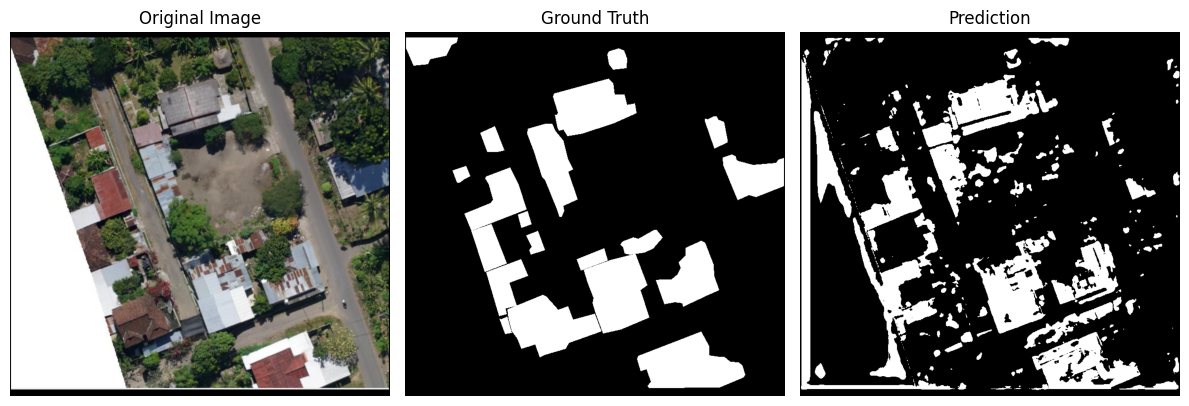

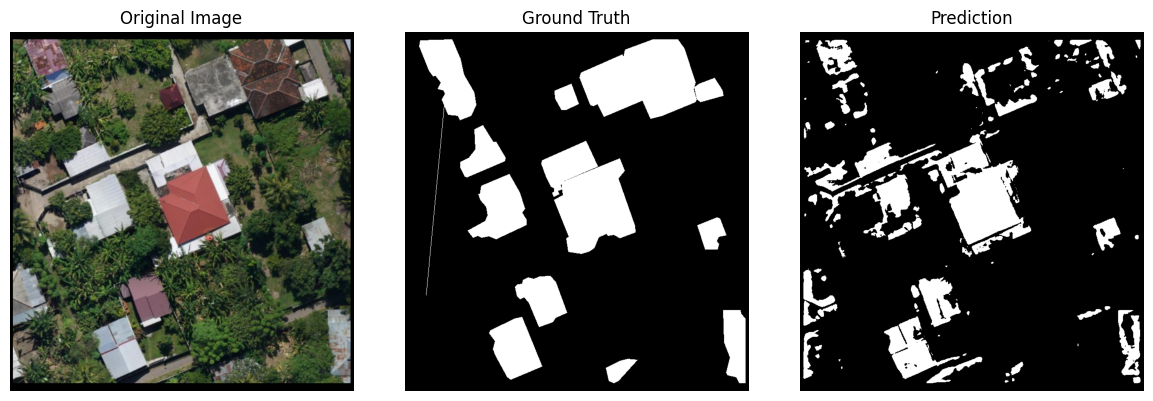

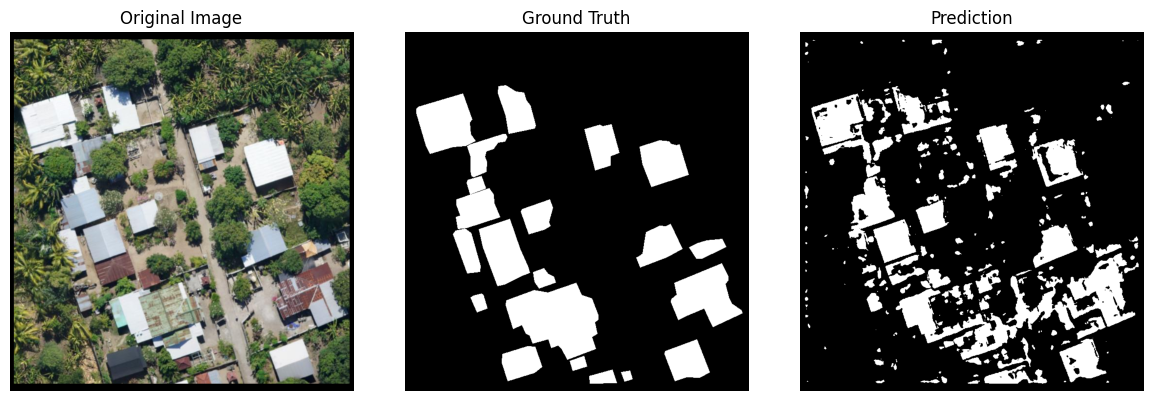

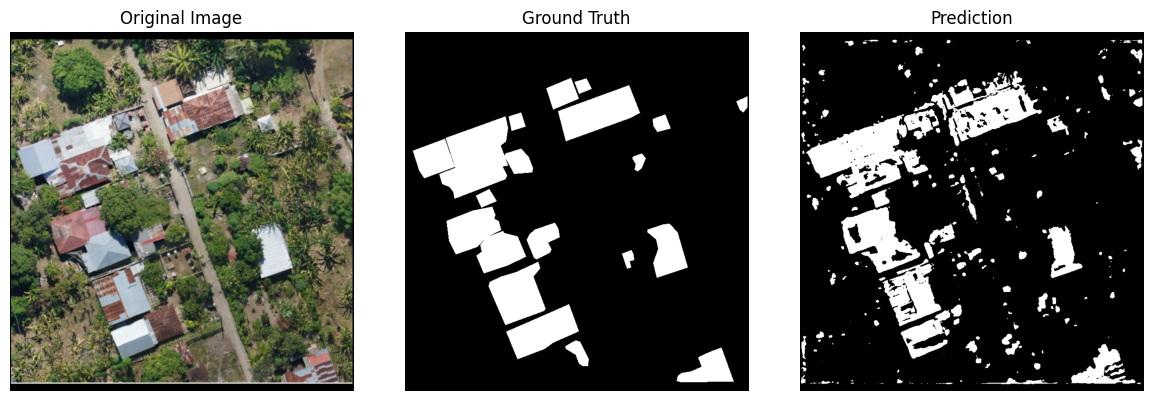

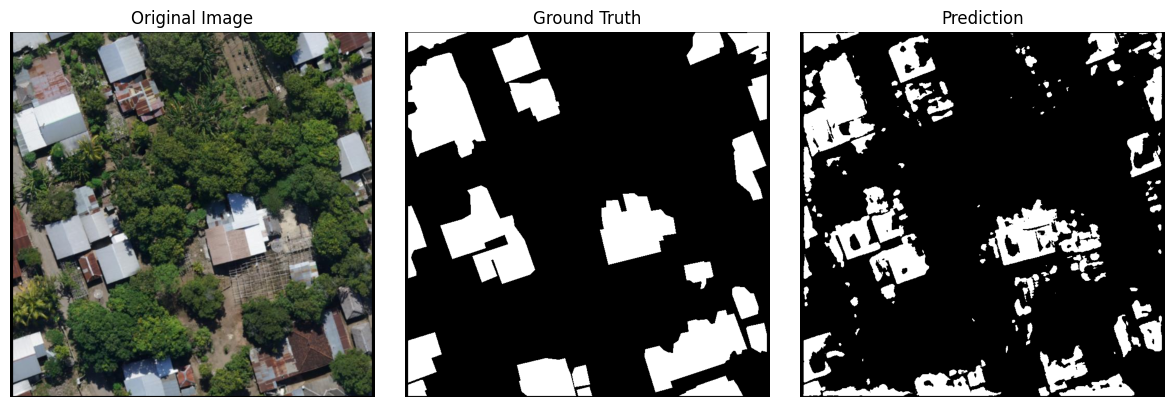

In [107]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
visualize_prediction(model, test_loader, device, num_samples=5)
